In [1]:
import os
import numpy as np
import pandas as pd

module_path = '/Users/morton/PycharmProjects/freerec'
data_file = os.path.join(module_path, 'data', 'cfr_raw_data_subset.csv')

In [2]:
df = pd.read_csv(data_file, index_col=['trial_type', 'list', 'item'])
df

subject  position
trial_type list item                                    
study      1    TOWEL                        1         1
                LADLE                        1         2
                THERMOS                      1         3
                LEGO                         1         4
                BACKPACK                     1         5
...                                        ...       ...
recall     48   CHRISTOPHER WALKEN           2         9
                BAYONET                      2        10
                VACUUM CLEANER               2        11
                MARTIN LUTHER KING JR        2        12
                PARIS HILTON                 2        13

[3610 rows x 2 columns]

In [3]:
study = df.loc['study'].copy()
study.loc[:, 'input'] = study['position']
recall = df.loc['recall'].copy()
recall.loc[:, 'output'] = recall['position']

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [4]:
study

subject  position  input
list item                                     
1    TOWEL                  1         1      1
     LADLE                  1         2      2
     THERMOS                1         3      3
     LEGO                   1         4      4
     BACKPACK               1         5      5
...                       ...       ...    ...
48   QUEEN ELIZABETH        2        20     20
     BUNKER HILL            2        21     21
     MOUNT BLANC            2        22     22
     GARLIC                 2        23     23
     BAYONET                2        24     24

[2304 rows x 3 columns]

In [5]:
recall.subject.isna().any()

False

In [6]:
keys = ['subject', 'list', 'item']
dfm = pd.merge(df.loc['study'].reset_index(), df.loc['recall'].reset_index(), 
               left_on=keys, right_on=keys, how='outer')

In [7]:
dfi = (dfm
       .rename(columns={'subject_x': 'subject'})
       .set_index(['subject', 'list', 'item'])
       .reindex(columns={'position_x', 'position_y'})
       .rename(columns={'position_x': 'input', 'position_y': 'output'}))

In [8]:
dfi

input  output
subject list item                            
1       1    TOWEL                1.0    13.0
             LADLE                2.0     NaN
             THERMOS              3.0     NaN
             LEGO                 4.0    18.0
             BACKPACK             5.0    10.0
...                               ...     ...
2       40   BUCKINGHAM PALACE    NaN     3.0
        42   HONG KONG            NaN    13.0
             GRAND CANYON         NaN    15.0
        43   PLYMOUTH VILLAGE     NaN    11.0
        44   BOOK                 NaN    11.0

[2463 rows x 2 columns]

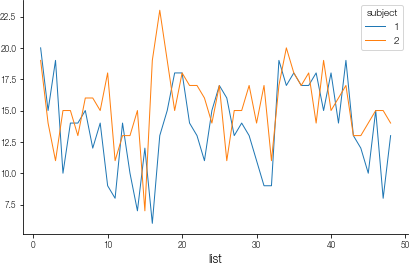

In [9]:
dfn = dfi.copy()
n_recall = dfn.groupby(['subject', 'list'])['output'].nunique()
n_recall.unstack().T.plot();

In [10]:
dfi

input  output
subject list item                            
1       1    TOWEL                1.0    13.0
             LADLE                2.0     NaN
             THERMOS              3.0     NaN
             LEGO                 4.0    18.0
             BACKPACK             5.0    10.0
...                               ...     ...
2       40   BUCKINGHAM PALACE    NaN     3.0
        42   HONG KONG            NaN    13.0
             GRAND CANYON         NaN    15.0
        43   PLYMOUTH VILLAGE     NaN    11.0
        44   BOOK                 NaN    11.0

[2463 rows x 2 columns]

In [11]:
dfi.loc[:, 'recalled'] = dfi['output'].notna().astype('int')
dfi

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


input  output  recalled
subject list item                                      
1       1    TOWEL                1.0    13.0         1
             LADLE                2.0     NaN         0
             THERMOS              3.0     NaN         0
             LEGO                 4.0    18.0         1
             BACKPACK             5.0    10.0         1
...                               ...     ...       ...
2       40   BUCKINGHAM PALACE    NaN     3.0         1
        42   HONG KONG            NaN    13.0         1
             GRAND CANYON         NaN    15.0         1
        43   PLYMOUTH VILLAGE     NaN    11.0         1
        44   BOOK                 NaN    11.0         1

[2463 rows x 3 columns]

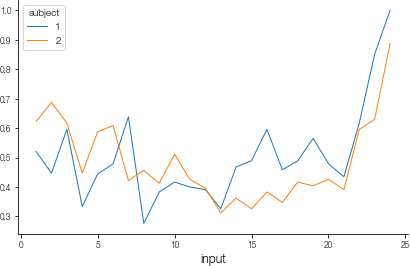

In [12]:
# only the first recall of an item counts
dfr = dfi.copy()
dfr = dfr.groupby(['subject', 'input', 'item']).first()
dfr.groupby(['subject', 'input'])['recalled'].mean().unstack().T.plot()